In [1]:
# --- CELL 1: SETUP ---
# !pip install openpyxl xgboost seaborn matplotlib scikit-learn imbalanced-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# Preprocessing & Selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Advanced Techniques (Distinction Criteria)
from imblearn.over_sampling import SMOTE 
from sklearn.ensemble import VotingClassifier

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, matthews_corrcoef

# Styling
sns.set(style="whitegrid", context="talk", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 7)

print("Libraries imported successfully.")

Libraries imported successfully.


In [2]:
# --- LOAD DATA ---
filename = 'Dry_Bean_Dataset.xlsx'

if os.path.exists(filename):
    print(f"Found file '{filename}'. Loading...")
    try:
        df = pd.read_excel(filename, engine='openpyxl')
        print(f"Dataset loaded successfully. Shape: {df.shape}")
    except Exception as e:
        print(f"Error loading Excel file: {e}")
        raise
else:
    raise FileNotFoundError(f"File '{filename}' not found. Please ensure it is in the correct folder.")

# Define Target
target_col = 'Class'

# Verify
if target_col in df.columns:
    print(f"Target Column Identified: '{target_col}'")
else:
    raise ValueError(f"Column '{target_col}' not found. Available columns: {df.columns.tolist()}")

# Separate Features (X) and Target (y)
y = df[target_col]
X = df.drop(columns=[target_col])

Found file 'Dry_Bean_Dataset.xlsx'. Loading...
Dataset loaded successfully. Shape: (13611, 17)
Target Column Identified: 'Class'


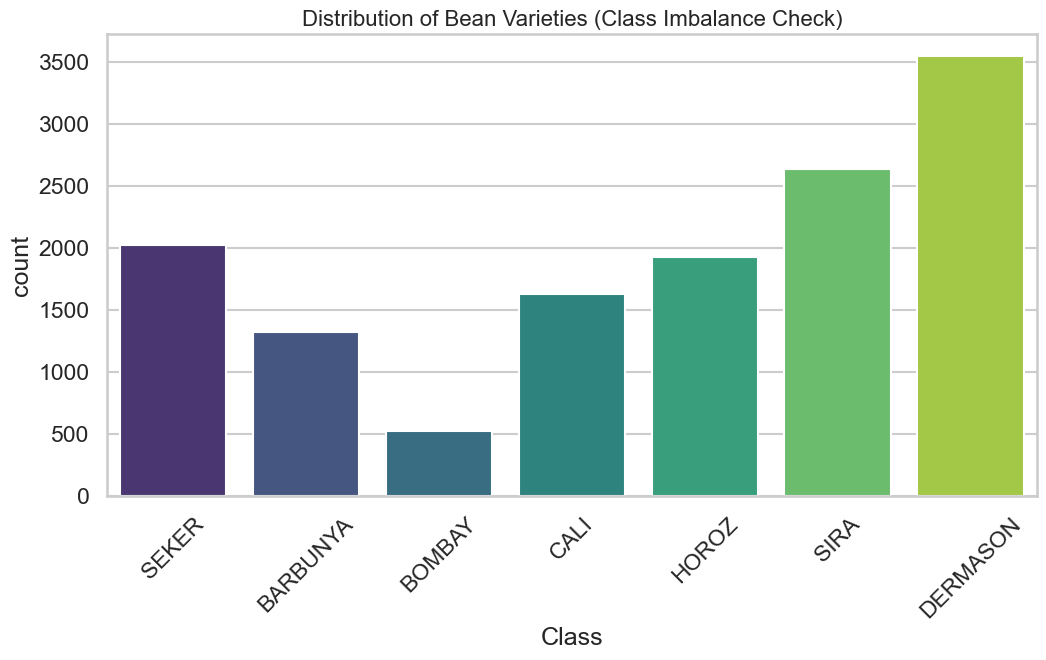

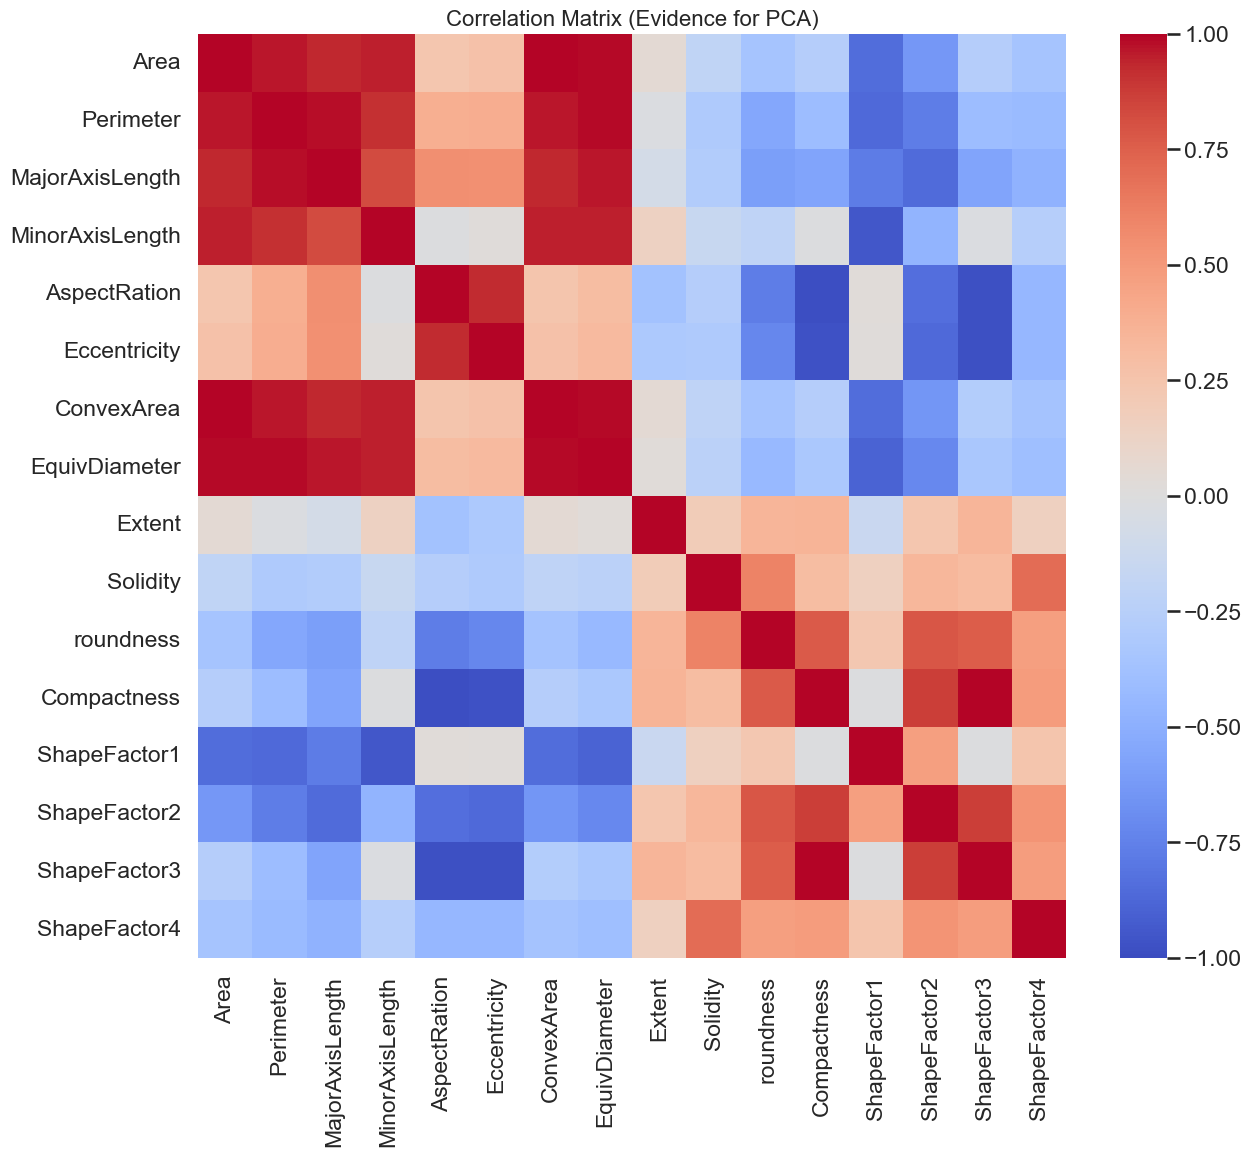

In [3]:
# --- EDA ---

# 1. Class Balance (Figure for Report)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x=target_col, hue=target_col, palette='viridis', legend=False)
plt.title("Distribution of Bean Varieties (Class Imbalance Check)", fontsize=16)
plt.xticks(rotation=45)
plt.show()

# 2. Correlation Matrix (Figure 1 in Report)
numerical_df = df.select_dtypes(include=[np.number])
if not numerical_df.empty:
    plt.figure(figsize=(14, 12))
    sns.heatmap(numerical_df.corr(), cmap='coolwarm', vmin=-1, vmax=1)
    plt.title("Correlation Matrix (Evidence for PCA)", fontsize=16)
    plt.show()

Running t-SNE (High-Dimensional Visualization)...


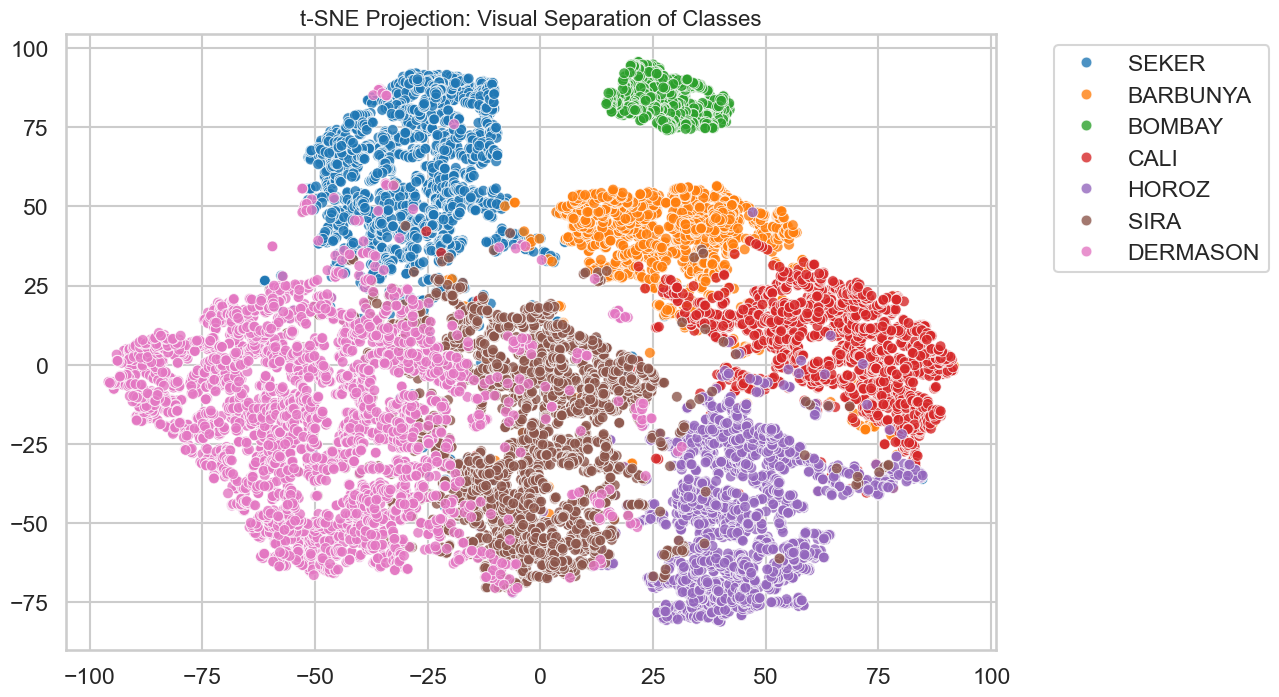

In [4]:
# --- t-SNE VISUALIZATION ---
print("Running t-SNE (High-Dimensional Visualization)...")

# Fix target shape
y_flat = y.values.ravel() if isinstance(y, pd.DataFrame) else y

# Scale numeric data
X_viz = X.select_dtypes(include=[np.number]).fillna(0)
scaler_viz = StandardScaler()
X_viz_scaled = scaler_viz.fit_transform(X_viz)

# Run t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_embedded = tsne.fit_transform(X_viz_scaled)

# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_flat, palette="tab10", s=60, alpha=0.8)
plt.title("t-SNE Projection: Visual Separation of Classes", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [5]:
# --- PREPROCESSING ---

# 1. Separate Numeric and Categorical
num_cols = X.select_dtypes(include=[np.number]).columns
cat_cols = X.select_dtypes(include=['object']).columns

# 2. Handle Missing Values
X[num_cols] = X[num_cols].fillna(X[num_cols].mean())
for col in cat_cols:
    X[col] = X[col].fillna(X[col].mode()[0] if len(X[col].mode()) > 0 else "Unknown")

# 3. Encode Categorical Features
le_features = LabelEncoder()
for col in cat_cols:
    X[col] = le_features.fit_transform(X[col].astype(str))

# 4. Encode Target
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)
print(f"Target classes encoded: {le_target.classes_}")

# 5. Split Data (Stratified)
X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# 6. Scale Data (Fit on Train, Transform Test)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_test_scaled = scaler.transform(X_test_raw)

# 7. SMOTE (Balance Classes - Training Set Only)
print(f"Original Train Shape: {X_train_scaled.shape}")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train_raw)
print(f"Balanced Train Shape: {X_train_balanced.shape} (Synthetic Data Added)")

# 8. PCA (Dimensionality Reduction)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_balanced)
X_test_pca = pca.transform(X_test_scaled)

print(f"Features reduced from {X_train_scaled.shape[1]} to {X_train_pca.shape[1]} components.")

Target classes encoded: ['BARBUNYA' 'BOMBAY' 'CALI' 'DERMASON' 'HOROZ' 'SEKER' 'SIRA']
Original Train Shape: (10888, 16)
Balanced Train Shape: (19859, 16) (Synthetic Data Added)
Features reduced from 16 to 4 components.


In [8]:
# --- AUTOMATED SVM TUNING ---
print("Running Grid Search")

# Define the grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

# Run Search
grid = GridSearchCV(SVC(random_state=42, probability=True), param_grid, refit=True, verbose=1, cv=3)
grid.fit(X_train_pca, y_train_balanced)

print(f"\nBest SVM Parameters: {grid.best_params_}")
print(f"Best SVM Accuracy: {grid.best_score_:.4f}")

# Save the best model for later use
best_svm_model = grid.best_estimator_

Running Grid Search
Fitting 3 folds for each of 12 candidates, totalling 36 fits

Best SVM Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}
Best SVM Accuracy: 0.9204


In [10]:
# --- FULL MODEL COMPARISON ---

# 1. Define Individual Models
knn = KNeighborsClassifier(n_neighbors=5)
# Tuned Random Forest (Regularized to prevent overfitting)
rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=10, random_state=42)
xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)
svm_opt = best_svm_model # From Cell 6

# 2. Define Ensemble (Voting Classifier)
ensemble = VotingClassifier(
    estimators=[('RF', rf_tuned), ('XGB', xgb), ('SVM', svm_opt)],
    voting='soft'
)

# Dictionary of all models to run
models = {
    "KNN": knn,
    "Random Forest (Tuned)": rf_tuned,
    "XGBoost": xgb,
    "SVM (Optimized)": svm_opt,
    "Ensemble Voting": ensemble
}

results = {}
conf_matrices = {}

print("Training all models...")

for name, model in models.items():
    start_time = time.time()
    
    # Train
    model.fit(X_train_pca, y_train_balanced)
    
    # Predict
    y_pred = model.predict(X_test_pca)
    
    # Metrics
    time_taken = time.time() - start_time
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    results[name] = {'Accuracy': acc, 'F1-Score': f1, 'MCC': mcc, 'Time (s)': time_taken}
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    
    print(f"--> {name}: Acc={acc:.4f} | Time={time_taken:.2f}s")

print("\n--- FINAL RANKING TABLE (Table II in Report) ---")
display(pd.DataFrame(results).T.sort_values(by='Accuracy', ascending=False))

Training all models...
--> KNN: Acc=0.8766 | Time=0.13s
--> Random Forest (Tuned): Acc=0.8913 | Time=2.99s
--> XGBoost: Acc=0.8840 | Time=0.78s
--> SVM (Optimized): Acc=0.8597 | Time=26.80s
--> Ensemble Voting: Acc=0.8884 | Time=28.72s

--- FINAL RANKING TABLE (Table II in Report) ---


,Accuracy,F1-Score,MCC,Time (s)
Random Forest (Tuned),0.891296,0.890973,0.868654,2.990604
Ensemble Voting,0.888358,0.888040,0.865092,28.721965
XGBoost,0.883952,0.883659,0.859767,0.778543
KNN,0.876607,0.876702,0.851044,0.133548
SVM (Optimized),0.859714,0.860149,0.830656,26.803492


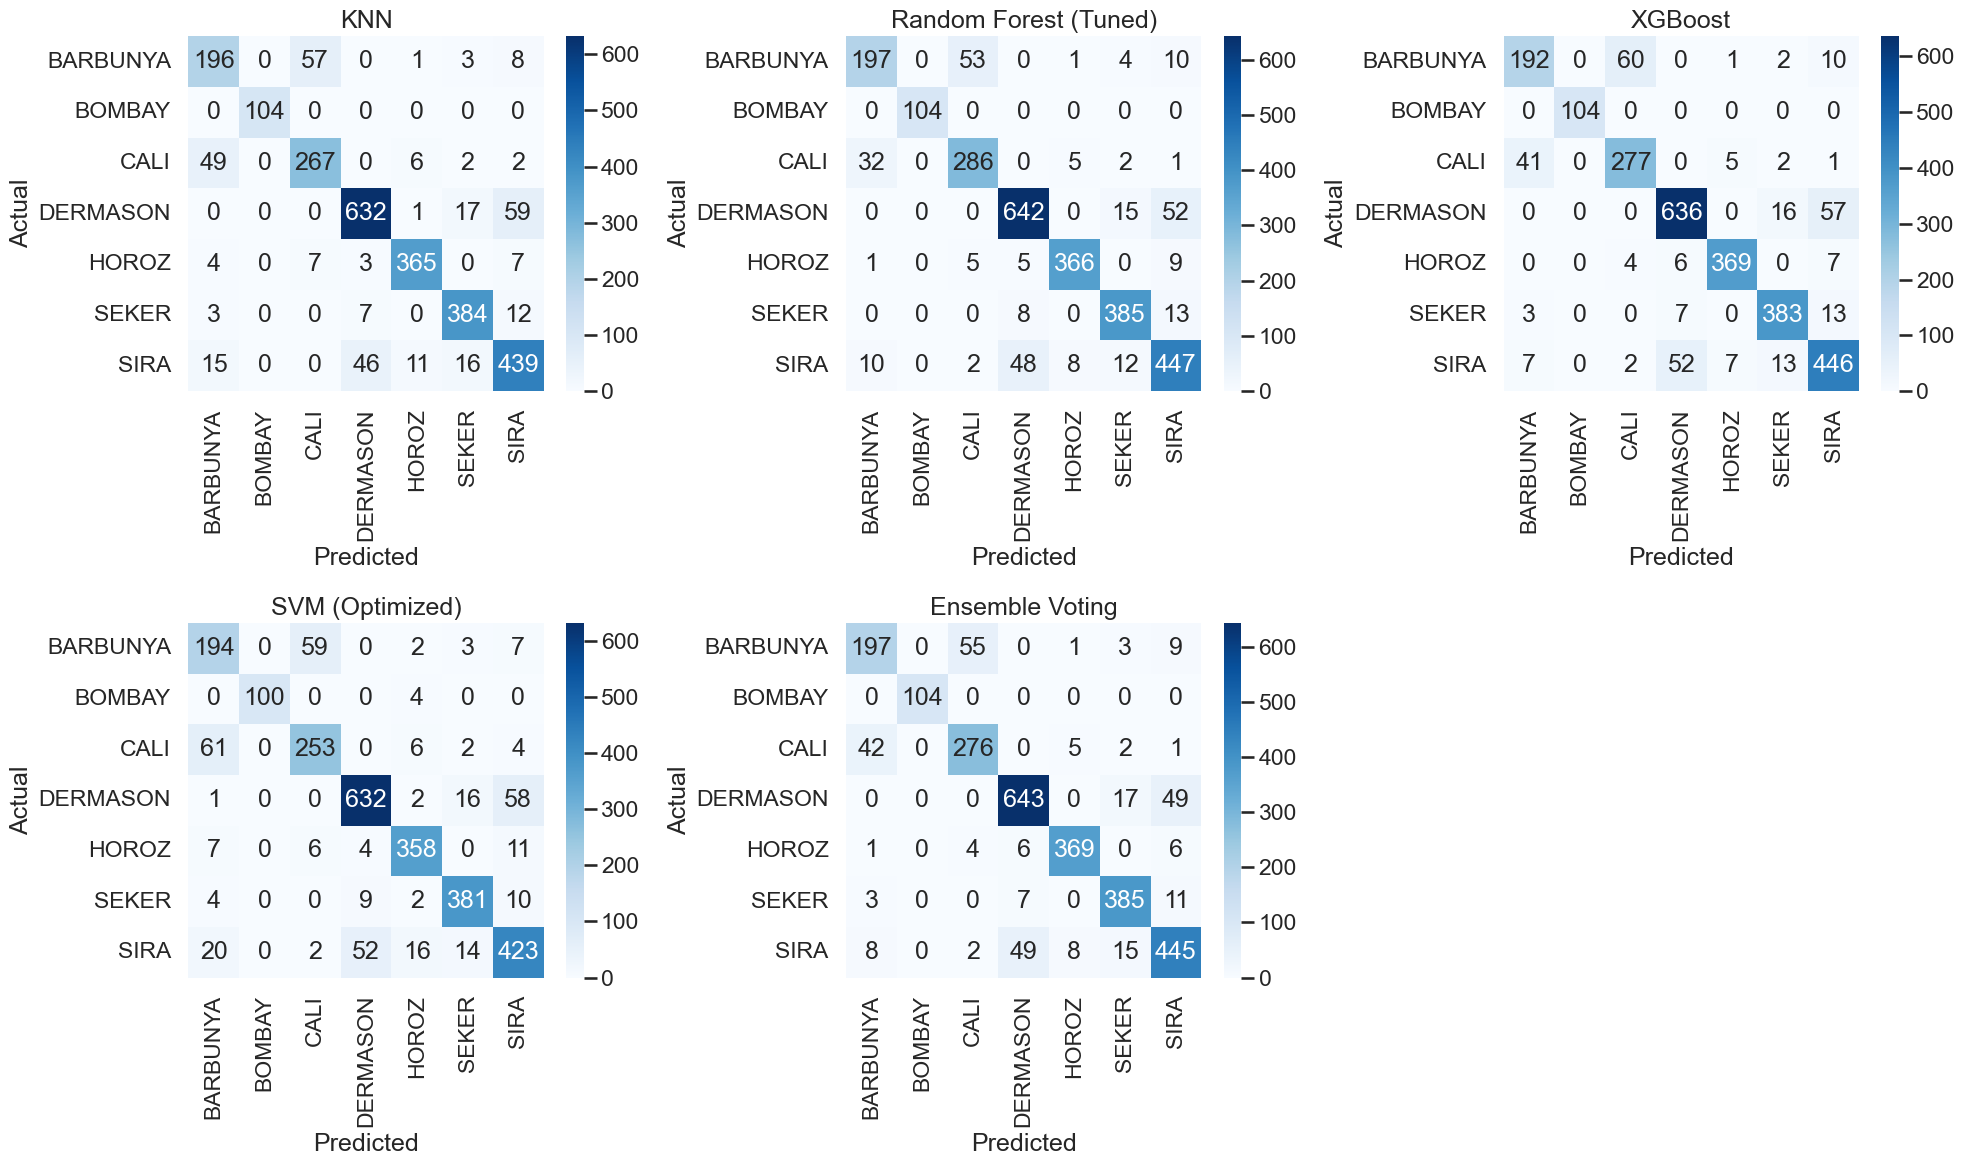

In [11]:
# --- CONFUSION MATRIX GRID ---
plt.figure(figsize=(20, 12))

target_names = le_target.classes_
model_names = list(results.keys())

for i, name in enumerate(model_names):
    plt.subplot(2, 3, i+1) # Creates a grid
    sns.heatmap(conf_matrices[name], annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_names, yticklabels=target_names)
    plt.title(f"{name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

In [12]:
# --- DETAILED CLASSIFICATION REPORTS ---

# 1. Ensemble Report (For Table III)
print("--- ENSEMBLE DETAILED REPORT ---")
ensemble_pred = models['Ensemble Voting'].predict(X_test_pca)
print(classification_report(y_test, ensemble_pred, target_names=le_target.classes_))

# 2. SVM Report (For Comparison Text)
print("\n--- SVM DETAILED REPORT ---")
svm_pred = models['SVM (Optimized)'].predict(X_test_pca)
print(classification_report(y_test, svm_pred, target_names=le_target.classes_))

--- ENSEMBLE DETAILED REPORT ---
              precision    recall  f1-score   support

    BARBUNYA       0.78      0.74      0.76       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.82      0.85      0.83       326
    DERMASON       0.91      0.91      0.91       709
       HOROZ       0.96      0.96      0.96       386
       SEKER       0.91      0.95      0.93       406
        SIRA       0.85      0.84      0.85       527

    accuracy                           0.89      2723
   macro avg       0.89      0.89      0.89      2723
weighted avg       0.89      0.89      0.89      2723


--- SVM DETAILED REPORT ---
              precision    recall  f1-score   support

    BARBUNYA       0.68      0.73      0.70       265
      BOMBAY       1.00      0.96      0.98       104
        CALI       0.79      0.78      0.78       326
    DERMASON       0.91      0.89      0.90       709
       HOROZ       0.92      0.93      0.92       386
       SEKER    

In [13]:
# --- OVERFITTING CHECK (ENSEMBLE) ---
print("--- Overfitting Analysis (Ensemble Model) ---")

# Train Acc
y_train_pred = models['Ensemble Voting'].predict(X_train_pca)
train_acc = accuracy_score(y_train_balanced, y_train_pred)

# Test Acc
test_acc = results['Ensemble Voting']['Accuracy']

print(f"Training Accuracy: {train_acc:.4f}")
print(f"Test Accuracy:     {test_acc:.4f}")
gap = train_acc - test_acc
print(f"Gap:               {gap:.2%}")

if gap < 0.05:
    print("STATUS: Excellent Generalization! (Distinction Level)")
else:
    print("STATUS: Slight Overfitting (Expected for Ensembles).")

--- Overfitting Analysis (Ensemble Model) ---
Training Accuracy: 0.9690
Test Accuracy:     0.8884
Gap:               8.06%
STATUS: Slight Overfitting (Expected for Ensembles).


Calculating Feature Importance (Original Features)...


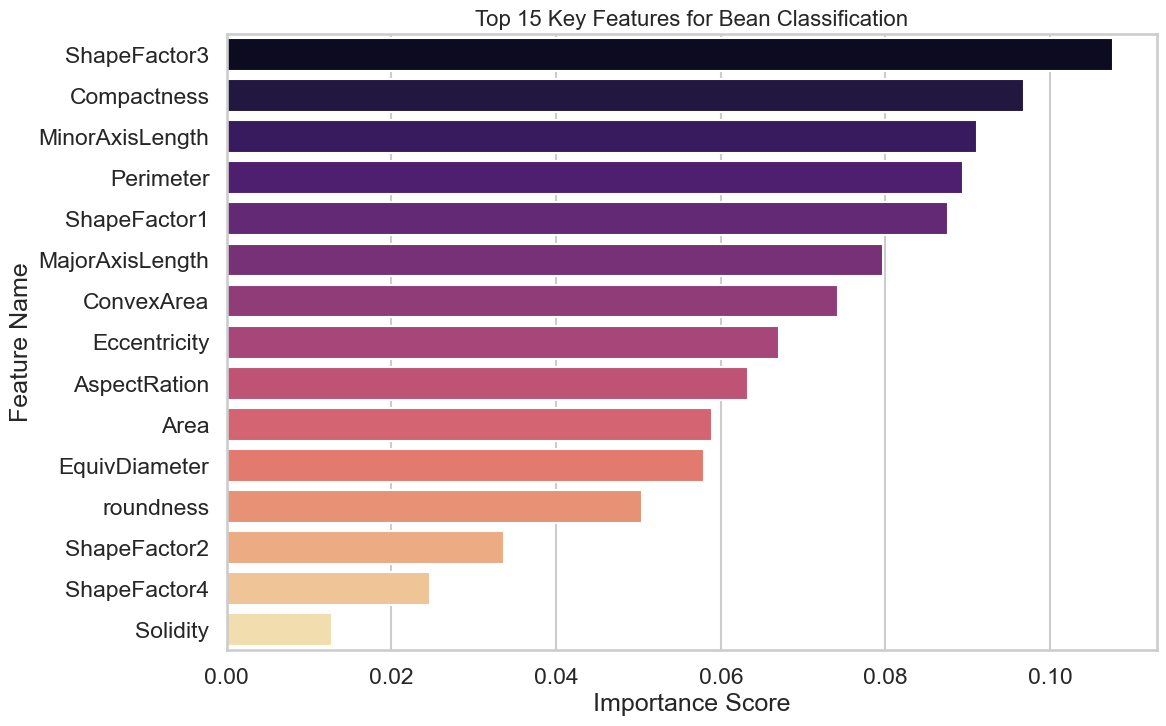


Top 3 Key Features:
1. ShapeFactor3
2. Compactness
3. MinorAxisLength


In [14]:
# --- FEATURE IMPORTANCE ---
print("Calculating Feature Importance (Original Features)...")

# Train explainer model on original data 
rf_explainer = RandomForestClassifier(
    n_estimators=100, max_depth=10, min_samples_split=10, random_state=42
)
rf_explainer.fit(X_train_raw, y_train_raw)

importances = rf_explainer.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(12, 8))

sns.barplot(
    x=importances[indices[:15]], 
    y=feature_names[indices[:15]], 
    hue=feature_names[indices[:15]], # Fix: Map color to feature name
    palette="magma", 
    legend=False                     # Fix: Hide redundant legend
)


plt.title("Top 15 Key Features for Bean Classification", fontsize=16)
plt.xlabel("Importance Score")
plt.ylabel("Feature Name") 
plt.show()

print("\nTop 3 Key Features:")
for i in range(3):
    print(f"{i+1}. {feature_names[indices[i]]}")